# Table of Content

- [1. Improting libraries](#1.0)

- [2. Reading Datasets](#2.0)

- [3.0 Preprocessing](3.0)

  - [3.1 Handling Missing values](#3.1)
  - [3.2 Handling Outlies](#3.2)
  - [3.3 Dublicated rows](#3.3)
  - [3.4 Dublicated columns](#3.4)
  - [3.5 unneeded columns](#1.5)

- [4.0 Feature constuction](#4.0)

- [5.0 Encoding](#5.0)

  - [5.1 Label encoding](#5.1)
  - [5.2 OneHotEnconding](#5.2)

- [6.0 Feature transaction](#6.0)

- [7.0 Splitting](#7.0)

- [8.0 SGDClassifier (sgdc)](#8.0)

  - [8.1 Build sgdc Model](#8.1)
  - [8.2 Evaluate sgdc Model](#8.2)

- [9.0 Decision-Trees (DTsC)](#9.0)

  - [9.1 Build DTsC Model](#9.1)
  - [9.2 Evaluate DTsC Model](#9.2)

- [10.0 RandomForestClassifier (RFC)](#10.0)

  - [10.1 Build RFC Model](#10.1)

- [11.0 CatBoostClassifier (CBC)](#11.0)

- [12.0 GradientBoostingClassifier (GBC)](#12.0)

  - [12.1 Build GBC Model](#12.1)
  - [12.2 Evaluate GBC Model](#12.)

- [13.0 XGBClassifier (XGBC)](#13.0)
  - [13.1 Build XGBC Model](#13.1)


- [1. Improting libraries](#1.0)


In [2]:
# algebra
import numpy as np

# dataframes
import pandas as pd

# EDA & visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# log
import math

# spliting and optimizing models
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# linear model
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
    Lasso,
    Ridge,
    ElasticNet,
)

# Trees
from sklearn.tree import plot_tree, DecisionTreeClassifier, ExtraTreeClassifier


# Ensembles
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)

# SVMs
from sklearn.svm import SVC

# Feature preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder,
)

# Model scoring
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
import warnings

# model pipelining
from sklearn.pipeline import Pipeline

# Selection
from sklearn.feature_selection import (
    chi2,
    VarianceThreshold,
    f_classif,
    SelectKBest,
    SelectPercentile,
    SequentialFeatureSelector,
)
from sklearn.compose import ColumnTransformer


from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

- [2. Reading Datasets](#2.0)


In [3]:
bank_df_train = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Binary Classification with a Bank Churn Dataset/dataset/train.csv"
)
bank_df_test = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Binary Classification with a Bank Churn Dataset/dataset/test.csv",
)
data = {
    "model": [],
    "train_score": [],
    "test_score": [],
    "1_error": [],
    "0_error": [],
}
models_used = pd.DataFrame(columns=data)


ids = bank_df_test["id"]
bank_df_test.drop(columns=["id"], axis=1, inplace=True)
combine = [bank_df_test, bank_df_train]

In [4]:
mapper = {
    "CustomerId": "customer_id",
    "Surname": "name",
    "Geography": "country",
    "Gender": "gender",
    "Age": "age",
    "CreditScore": "score",
    "Tenure": "number_of_years",
    "Balance": "balance",
    "NumOfProducts": "used_products",
    "HasCrCard": "has_card",
    "IsActiveMember": "activeness",
    "EstimatedSalary": "salary",
    "Exited": "target",
}

for dataset in combine:
    dataset.rename(columns=mapper, inplace=True)

for dataset in combine:
    print(dataset.columns)
    print()

Index(['customer_id', 'name', 'score', 'country', 'gender', 'age',
       'number_of_years', 'balance', 'used_products', 'has_card', 'activeness',
       'salary'],
      dtype='object')

Index(['id', 'customer_id', 'name', 'score', 'country', 'gender', 'age',
       'number_of_years', 'balance', 'used_products', 'has_card', 'activeness',
       'salary', 'target'],
      dtype='object')



# [3.0 Preprocessing](3.0)


- [3.1 Handling Missing values](#3.1)


In [5]:
for feature in bank_df_train.columns:
    if bank_df_train[feature].isnull().sum() > 0:
        print(feature)

print()

for feature in bank_df_test.columns:
    if bank_df_test[feature].isnull().sum() > 0:
        print(feature)

There is no null values


[3.2 Handling Outlies](#3.2)


In [6]:
def get_outliers(feature):
    Q1 = bank_df_train[feature].quantile(0.25)
    Q2 = bank_df_train[feature].quantile(0.75)
    iqr = Q2 - Q1
    lower_limit = Q1 - 1.5 * iqr
    upper_limit = Q2 + 1.5 * iqr
    IQR_df = bank_df_train[
        (bank_df_train[feature] < lower_limit) | (bank_df_train[feature] > upper_limit)
    ]
    return (len(IQR_df)), lower_limit, upper_limit


for feature in bank_df_train.columns:
    if (
        bank_df_train[feature].dtype == "O"
        or feature == "target"
        or len(bank_df_train[feature].value_counts()) < 11
    ):
        continue
    outs, low, uper = get_outliers(feature)
    if outs:
        bank_df_train = bank_df_train[
            (bank_df_train[feature] >= low) & (bank_df_train[feature] <= uper)
        ]

[3.3 Dublicated rows](#3.3)


In [7]:
Dublicated_rows_train = bank_df_train[bank_df_train.duplicated()]
Dublicated_rows_test = bank_df_test[bank_df_test.duplicated()]
len(Dublicated_rows_train), len(Dublicated_rows_test)

(0, 0)

There is no Dublicated rows


- [3.4 Dublicated columns](#3.4)


In [8]:
def get_duplicate_columns(df=pd.DataFrame):

    duplicate_columns = {}
    seen_columns = {}

    for column in df.columns:
        current_column = df[column]
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns


duplicate_columns_train = get_duplicate_columns(bank_df_train)
duplicate_columns_test = get_duplicate_columns(bank_df_test)

duplicate_columns_train, duplicate_columns_test

({}, {})

There is no Dublicated columns


[3.5 unneeded columns](#1.5)


In [9]:
bank_df_test.drop(columns=["name", "customer_id"], axis="columns", inplace=True)
bank_df_train.drop(columns=["name", "customer_id", "id"], axis="columns", inplace=True)
combine = [bank_df_test, bank_df_train]

# [4.0 Feature constuction](#4.0)


The columns i will constuct

    hasCard_and_use_products = has_card == 1 and used_products > 0

    new_customer = number_of_years > 0

    products_by_year = used_products / number_of_years

    balance_salary = balance + salary

    salary_range = dividing salary to ranges

    score_range = dividing score to ranges

    age_ranges = dividing age to ranges

    number_of_years_range = dividing number_of_years to ranges


In [10]:
for dataset in combine:

    dataset["hasCard_and_use_products"] = (dataset["has_card"] == 1) & (
        dataset["used_products"] > 0
    )
    dataset["new_customer"] = dataset["number_of_years"] > 1
    dataset["products_by_year"] = dataset["used_products"] / dataset["number_of_years"]
    dataset["products_by_year"] = np.ceil(dataset["products_by_year"])
    dataset["products_by_year"] = dataset["products_by_year"].replace(np.inf, 0)
    dataset["balance_salary"] = dataset["balance"] + dataset["salary"]
    dataset["hasCard_and_use_products"] = dataset["hasCard_and_use_products"].astype(
        "int32"
    )
    dataset["new_customer"] = dataset["new_customer"].astype("int32")

In [11]:
def salary_range(salary):
    if salary < 20000:
        return 0
    if salary < 50000:
        return 1
    if salary < 100000:
        return 2
    if salary < 150000:
        return 3
    if salary < 180000:
        return 4
    return 5


def score_range(score):
    if score < 300:
        return 0
    if score < 450:
        return 1
    if score < 550:
        return 2
    if score < 650:
        return 3
    return 4


def age_ranges(age):
    if age < 35:
        return 0
    if age < 50:
        return 1
    if age < 60:
        return 2
    if age < 75:
        return 3
    return 4


def number_of_years_range(years):
    if years < 2:
        return 0
    if years < 5:
        return 1
    if years < 8:
        return 3
    return 4


for dataset in combine:
    dataset["salary_range"] = dataset["salary"].apply(salary_range)
    dataset["score_range"] = dataset["score"].apply(score_range)
    dataset["age_ranges"] = dataset["age"].apply(age_ranges)
    dataset["number_of_years_range"] = dataset["number_of_years"].apply(
        number_of_years_range
    )

# [5.0 Encoding](#5.0)


- [5.2 OneHotEnconding](#5.2)


In [12]:
bank_df_test = pd.get_dummies(bank_df_test, columns=["country", "gender"])
bank_df_train = pd.get_dummies(bank_df_train, columns=["country", "gender"])
combine = [bank_df_test, bank_df_train]

for dataset in combine:
    for feature in dataset:
        if dataset[feature].dtype == "bool":
            dataset[feature] = dataset[feature].astype("int32")

# [6.0 Feature transaction](#6.0)


In [13]:
target = bank_df_train["target"]
bank_df_train.drop(columns=["target"], axis=1, inplace=True)

FT = FunctionTransformer(np.log)
scaler = StandardScaler()
bank_df_train[["balance", "salary", "balance_salary"]] = (
    bank_df_train[["balance", "salary", "balance_salary"]] + 1
)

bank_df_train[["balance", "salary", "balance_salary"]] = FT.fit_transform(
    bank_df_train[["balance", "salary", "balance_salary"]]
)

bank_df_train = pd.DataFrame(
    scaler.fit_transform(bank_df_train), columns=bank_df_train.columns
)

In [14]:
FT = FunctionTransformer(np.log)
scaler = StandardScaler()
bank_df_test[["balance", "salary", "balance_salary"]] = (
    bank_df_test[["balance", "salary", "balance_salary"]] + 1
)

bank_df_test[["balance", "salary", "balance_salary"]] = FT.fit_transform(
    bank_df_test[["balance", "salary", "balance_salary"]]
)

bank_df_test = pd.DataFrame(
    scaler.fit_transform(bank_df_test), columns=bank_df_test.columns
)

# [7.0 Splitting](#7.0)


In [15]:
feature = bank_df_train
test = target

x_train, x_test, y_train, y_test = train_test_split(
    feature, test, test_size=0.3, random_state=42
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(110880, 21)
(110880,)
(47520, 21)
(47520,)


# [8.0 SGDClassifier (sgdc)](#8.0)


[8.1 Build sgdc Model](#8.1)


In [16]:
def build_SGD(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    train_score, test_score, used_alphas = [], [], []

    alpha = [
        0.00004,
        0.00005,
        0.00006,
        0.00007,
        0.00008,
        0.00009,
    ]

    alpha.sort()
    for alp in alpha:

        SGD = SGDClassifier(loss="log_loss", penalty="l1", alpha=alp, random_state=42)

        SGD.fit(x_train, y_train)

        train_acc = SGD.score(x_train, y_train)
        test_acc = SGD.score(x_test, y_test)
        train_score.append(train_acc)
        test_score.append(test_acc)
        used_alphas.append(alp)

    return train_score, test_score, used_alphas


train_score, test_score, used_alphas = build_SGD()

[8.2 Evaluate sgdc Model](#8.2)


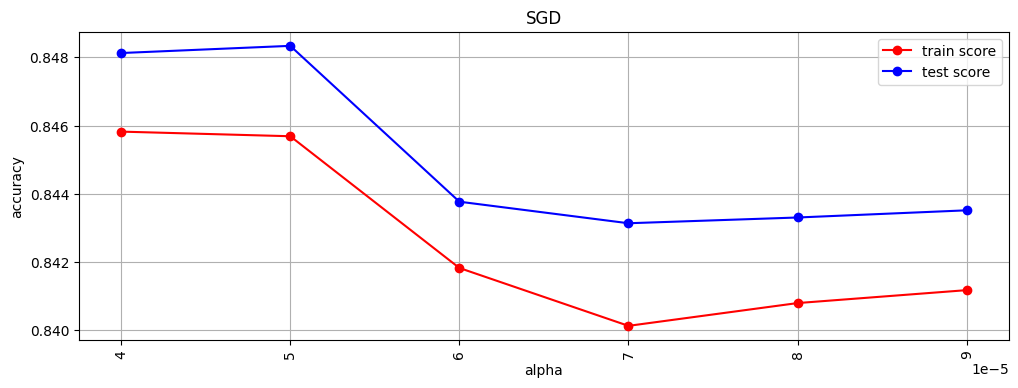

In [17]:
def evaluate_SGD(
    train_score=train_score, test_score=test_score, used_alphas=used_alphas
):
    plt.figure(figsize=(12, 4))

    plt.plot(used_alphas, train_score, color="red", marker="o", label="train score")
    plt.plot(used_alphas, test_score, color="blue", marker="o", label="test score")

    plt.xlabel("alpha")
    plt.ylabel("accuracy")
    plt.title("SGD")
    plt.grid(True)
    plt.xticks(used_alphas, rotation=90)
    plt.legend()
    plt.show()
    return


evaluate_SGD()

In [18]:
SGD = SGDClassifier(loss="log_loss", penalty="l1", alpha=5 * 1e-5, random_state=42)

SGD_pip = Pipeline(steps=[("SGDClassifier", SGD)])

SGD_pip.fit(x_train, y_train)

Pipeline(steps=[('SGDClassifier',
                 SGDClassifier(alpha=5e-05, loss='log_loss', penalty='l1',
                               random_state=42))])

In [19]:
train_acc = SGD_pip.score(x_train, y_train)
test_acc = SGD_pip.score(x_test, y_test)
train_acc, test_acc

(0.8456890331890332, 0.8483375420875421)

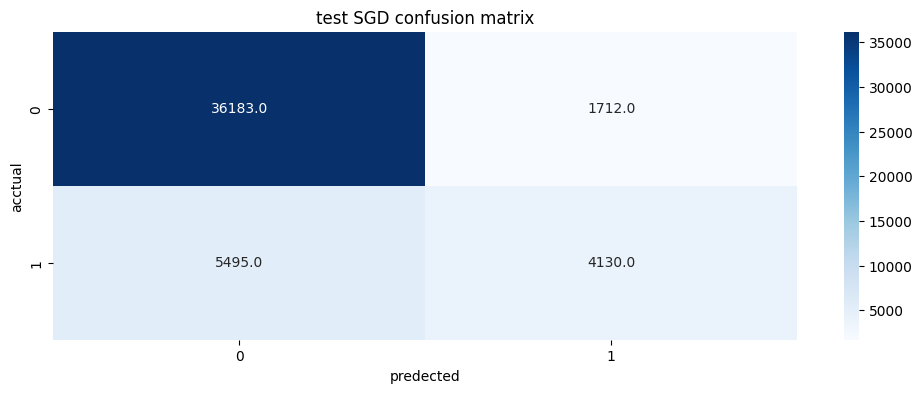

In [20]:
y_pred = SGD_pip.predict(x_test)

cm_SGD = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(cm_SGD, annot=True, cmap="Blues", fmt=".1f")
plt.title("test SGD confusion matrix")
plt.ylabel("acctual")
plt.xlabel("predected")
plt.show()

In [21]:
y_pred_train = SGD.predict(x_train)
y_pred__test = SGD.predict(x_test)

print("Classification Report - Train Data:")
print(classification_report(y_true=y_train, y_pred=y_pred_train))

print("Classification Report - Test Data:")
print(classification_report(y_true=y_test, y_pred=y_pred__test))

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91     88090
           1       0.71      0.42      0.53     22790

    accuracy                           0.85    110880
   macro avg       0.79      0.69      0.72    110880
weighted avg       0.83      0.85      0.83    110880

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     37895
           1       0.71      0.43      0.53      9625

    accuracy                           0.85     47520
   macro avg       0.79      0.69      0.72     47520
weighted avg       0.84      0.85      0.83     47520



In [22]:
data = {
    "model": "SGD",
    "train_score": train_acc,
    "test_score": test_acc,
    "1_error": 1712,
    "0_error": 5495,
}

models_used.loc[len(models_used)] = data

# [9.0 Decision-Trees (DTsC)](#9.0)


[9.1 Build DTsC Model](#9.1)


In [69]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(x_train, y_train)
DTC.score(x_train, y_train), DTC.score(x_test, y_test)

(0.9998286435786435, 0.8014520202020202)

[9.2 Evaluate DTsC Model](#9.2)


In [23]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]

used = []
models = []
for i in range(40):
    alpha = np.random.randint(40, len(alphas) - 1)
    used.append(alphas[alpha])
    DTC = DecisionTreeClassifier(random_state=42, ccp_alpha=alphas[alpha])
    DTC.fit(x_train, y_train)
    models.append(DTC)

In [24]:
train_score = [DTC_.score(x_train, y_train) for DTC_ in models]
test_score = [DTC_.score(x_test, y_test) for DTC_ in models]

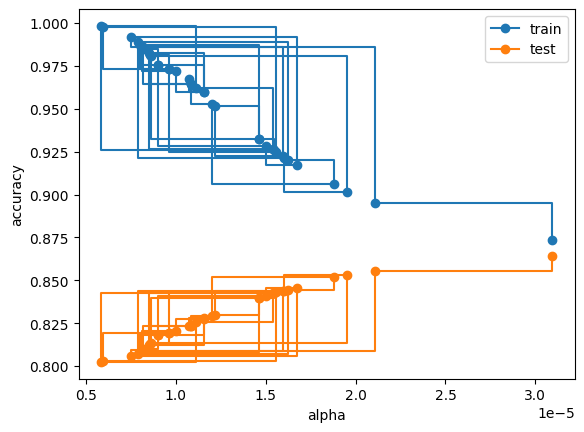

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(used, train_score, marker="o", label="train", drawstyle="steps-post")
ax.plot(used, test_score, marker="o", label="test", drawstyle="steps-post")
plt.legend()
plt.show()

In [34]:
alphas[(alphas > 3.2 * 1e-5) & (alphas < 3.3 * 1e-5)]

array([3.20964176e-05, 3.20977343e-05, 3.21598306e-05, 3.22665926e-05,
       3.23047581e-05, 3.23557297e-05, 3.23682267e-05, 3.24853148e-05,
       3.25300696e-05, 3.26275096e-05, 3.28897541e-05, 3.29878015e-05,
       3.29938450e-05, 3.29961896e-05])

In [23]:
alpha = 3.29961896e-05

DTC = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
DTC.fit(x_train, y_train)
train_acc = DTC.score(x_train, y_train)
test_acc = DTC.score(x_test, y_test)
train_acc, test_acc

(0.8721410533910534, 0.8648148148148148)

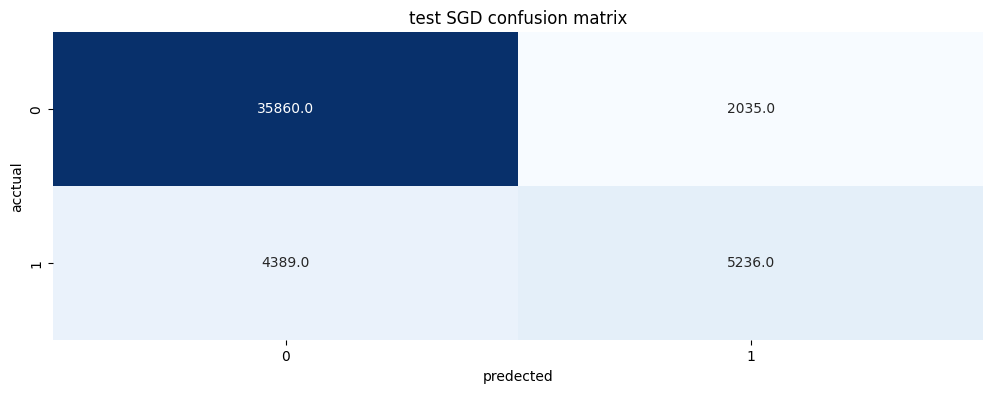

In [24]:
y_pred = DTC.predict(x_test)

cm_DTC = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(cm_DTC, annot=True, cmap="Blues", cbar=False, fmt=".1f")
plt.title("test SGD confusion matrix")
plt.ylabel("acctual")
plt.xlabel("predected")
plt.show()

In [25]:
y_pred_train = DTC.predict(x_train)
y_pred__test = DTC.predict(x_test)

print("Classification Report - Train Data:")
print(classification_report(y_true=y_train, y_pred=y_pred_train))

print("Classification Report - Test Data:")
print(classification_report(y_true=y_test, y_pred=y_pred__test))

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     88090
           1       0.75      0.56      0.64     22790

    accuracy                           0.87    110880
   macro avg       0.82      0.76      0.78    110880
weighted avg       0.86      0.87      0.86    110880

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     37895
           1       0.72      0.54      0.62      9625

    accuracy                           0.86     47520
   macro avg       0.81      0.75      0.77     47520
weighted avg       0.86      0.86      0.86     47520



In [26]:
data = {
    "model": "DTCs",
    "train_score": train_acc,
    "test_score": test_acc,
    "1_error": 2035,
    "0_error": 4389,
}

models_used.loc[len(models_used)] = data

# [10.0 RandomForestClassifier (RFC)](#10.0)


[10.1 Build RFC Model](#10.1)


In [27]:
RF = RandomForestClassifier(
    criterion="entropy", n_estimators=100, random_state=42, ccp_alpha=3.29961896e-05
)
RF.fit(x_train, y_train)
train_acc = RF.score(x_train, y_train)
test_acc = RF.score(x_test, y_test)
train_acc, test_acc

(0.9359036796536796, 0.8664983164983165)

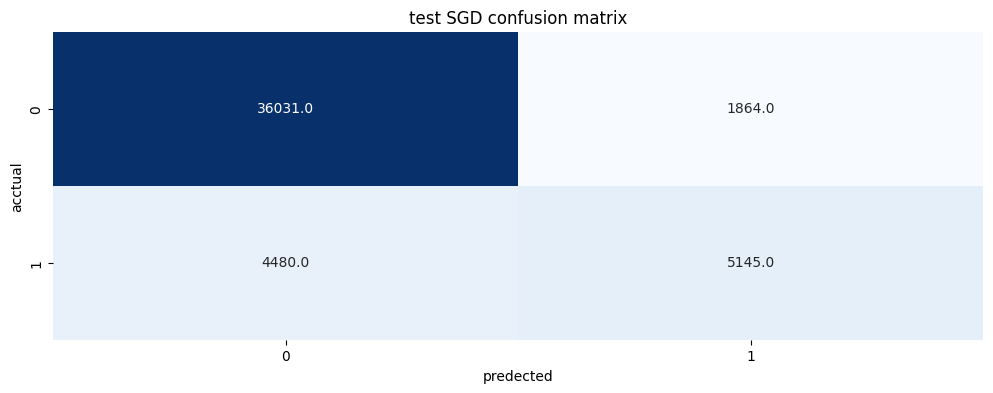

In [28]:
y_pred = RF.predict(x_test)

cm_RF = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(cm_RF, annot=True, cmap="Blues", cbar=False, fmt=".1f")
plt.title("test SGD confusion matrix")
plt.ylabel("acctual")
plt.xlabel("predected")
plt.show()

In [29]:
data = {
    "model": "RFs",
    "train_score": train_acc,
    "test_score": test_acc,
    "1_error": 1864,
    "0_error": 4480,
}

models_used.loc[len(models_used)] = data

# [11.0 CatBoostClassifier (CBC)](#11.0)


In [30]:
cat = CatBoostClassifier(iterations=10000, random_state=42, verbose=0)

cat_boost = Pipeline(steps=[("CatBoostClassifier", cat)])

cat_boost.fit(x_train, y_train)

Pipeline(steps=[('CatBoostClassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f0cc71b44f0>)])

In [31]:
train_acc = cat_boost.score(x_train, y_train)
test_acc = cat_boost.score(x_test, y_test)
train_acc, test_acc

(0.8847853535353535, 0.8686447811447812)

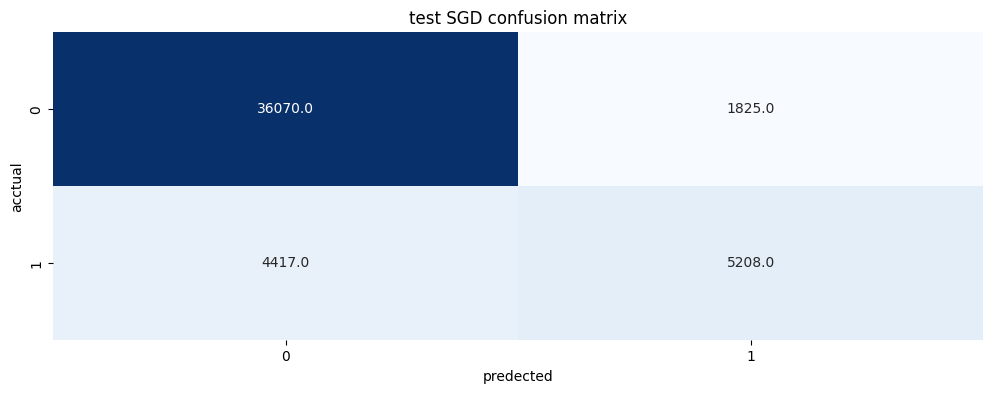

In [32]:
y_pred = cat_boost.predict(x_test)

cm_cat_boost = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(cm_cat_boost, annot=True, cmap="Blues", cbar=False, fmt=".1f")
plt.title("test SGD confusion matrix")
plt.ylabel("acctual")
plt.xlabel("predected")
plt.show()

In [33]:
data = {
    "model": "cat_boost",
    "train_score": train_acc,
    "test_score": test_acc,
    "1_error": 1825,
    "0_error": 4417,
}

models_used.loc[len(models_used)] = data

# [12.0 GradientBoostingClassifier (GBC)](#12.0)


[12.1 Build GBC Model](#12.1)


In [34]:
def build_GBC(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    train_score, test_score, used_learning_rate = [], [], []

    learning_rate = [0.1, 0.2, 0.3]

    learning_rate.sort()
    for learn in learning_rate:

        CBC = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=learn,
            criterion="squared_error",
            random_state=42,
        )

        CBC.fit(x_train, y_train)

        train_acc = CBC.score(x_train, y_train)
        test_acc = CBC.score(x_test, y_test)
        train_score.append(train_acc)
        test_score.append(test_acc)
        used_learning_rate.append(learn)

    return train_score, test_score, used_learning_rate


train_score, test_score, used_learning_rate = build_GBC()

[12.2 Evaluate GBC Model](#12.)


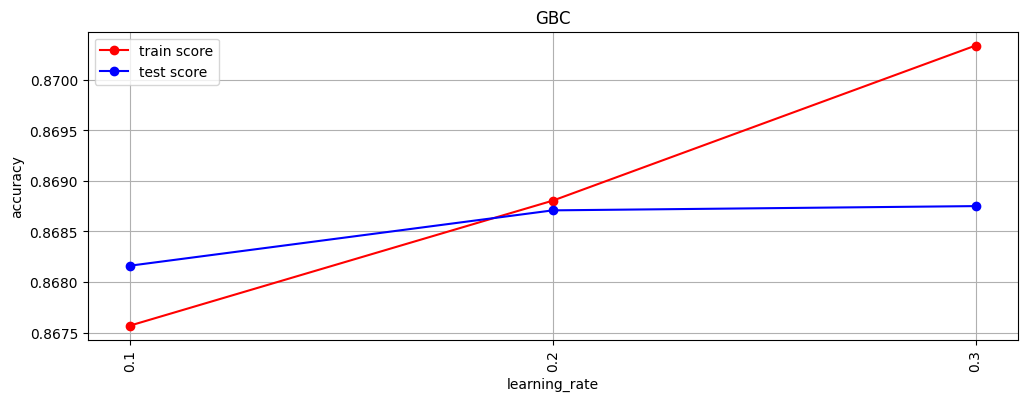

In [35]:
def evaluate_GBC(
    train_score=train_score,
    test_score=test_score,
    used_learning_rate=used_learning_rate,
):
    plt.figure(figsize=(12, 4))

    plt.plot(
        used_learning_rate, train_score, color="red", marker="o", label="train score"
    )
    plt.plot(
        used_learning_rate, test_score, color="blue", marker="o", label="test score"
    )

    plt.xlabel("learning_rate")
    plt.ylabel("accuracy")
    plt.title("GBC")
    plt.grid(True)
    plt.xticks(used_learning_rate, rotation=90)
    plt.legend()
    plt.show()
    return


evaluate_GBC()

In [36]:
GBC = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.3,
    criterion="squared_error",
    random_state=42,
)

GBC_pip = Pipeline(steps=[("GradientBoostingClassifier", GBC)])

GBC_pip.fit(x_train, y_train)

Pipeline(steps=[('GradientBoostingClassifier',
                 GradientBoostingClassifier(criterion='squared_error',
                                            learning_rate=0.3,
                                            random_state=42))])

In [37]:
train_acc = GBC_pip.score(x_train, y_train)
test_acc = GBC_pip.score(x_test, y_test)
train_acc, test_acc

(0.8703373015873016, 0.86875)

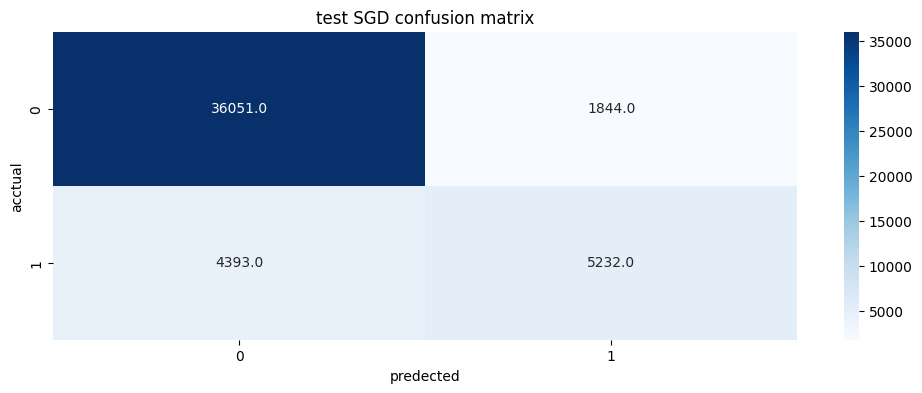

In [38]:
y_pred = GBC_pip.predict(x_test)

cm_SGD = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(cm_SGD, annot=True, cmap="Blues", fmt=".1f")
plt.title("test SGD confusion matrix")
plt.ylabel("acctual")
plt.xlabel("predected")
plt.show()

In [39]:
y_pred_train = GBC_pip.predict(x_train)
y_pred__test = GBC_pip.predict(x_test)

print("Classification Report - Train Data:")
print(classification_report(y_true=y_train, y_pred=y_pred_train))

print("Classification Report - Test Data:")
print(classification_report(y_true=y_test, y_pred=y_pred__test))

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     88090
           1       0.75      0.55      0.63     22790

    accuracy                           0.87    110880
   macro avg       0.82      0.75      0.78    110880
weighted avg       0.86      0.87      0.86    110880

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     37895
           1       0.74      0.54      0.63      9625

    accuracy                           0.87     47520
   macro avg       0.82      0.75      0.77     47520
weighted avg       0.86      0.87      0.86     47520



In [40]:
data = {
    "model": "GBC",
    "train_score": train_acc,
    "test_score": test_acc,
    "1_error": 1844,
    "0_error": 4393,
}

models_used.loc[len(models_used)] = data

# [13.0 XGBClassifier (XGBC)](#13.0)


[13.1 Build XGBC Model](#13.1)


In [41]:
XGBC = XGBClassifier(
    random_state=42,
)
XGBC.fit(x_train, y_train)
train_acc = XGBC.score(x_train, y_train)
test_acc = XGBC.score(x_test, y_test)

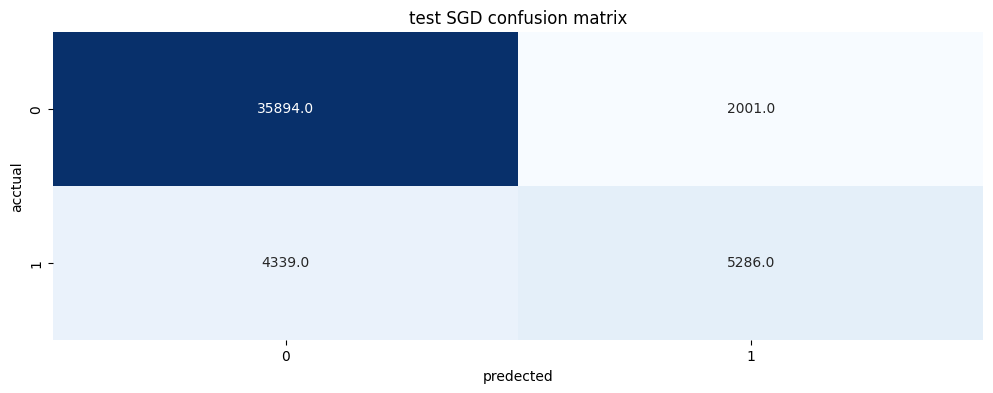

In [42]:
y_pred = XGBC.predict(x_test)

cm_XGBC = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(12, 4))
sns.heatmap(cm_XGBC, annot=True, cmap="Blues", cbar=False, fmt=".1f")
plt.title("test SGD confusion matrix")
plt.ylabel("acctual")
plt.xlabel("predected")
plt.show()

In [43]:
data = {
    "model": "XGBC",
    "train_score": train_acc,
    "test_score": test_acc,
    "1_error": 2001,
    "0_error": 4339,
}

models_used.loc[len(models_used)] = data

In [45]:
models_used.sort_values(by=["1_error", "0_error"], ascending=[True, True])

,model,train_score,test_score,1_error,0_error
0,SGD,0.845689,0.848338,1712,5495
3,cat_boost,0.884785,0.868645,1825,4417
4,GBC,0.870337,0.868750,1844,4393
2,RFs,0.935904,0.866498,1864,4480
5,XGBC,0.885868,0.866582,2001,4339
1,DTCs,0.872141,0.864815,2035,4389


In [80]:
prediction_proba = GBC.predict_proba(bank_df_test)
prediction_proba = prediction_proba[:, -1]

In [81]:
submmition = pd.DataFrame({"id": ids, "Exited": prediction_proba})
submmition.to_csv(
    "/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Binary Classification with a Bank Churn Dataset/dataset/submission.csv",
    index=False,
)